**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
df1 = pd.read_csv("/content/Daily_Gold_Price.csv")
df1.head()

,Date,Indian rupee (INR) per gram
0,01-01-1979,0.000000
1,02-01-1979,57.641466
2,03-01-1979,57.940468
3,04-01-1979,58.248794
4,05-01-1979,59.272152


**Data Analysis and splitting the data**

In [3]:
df1.head()
df1.isnull().sum()

Date                           0
Indian rupee (INR) per gram    0
dtype: int64

In [4]:
df2 = df1.drop(columns=['Date'])

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [6]:
df2

array([[0.        ],
       [0.01143285],
       [0.01149215],
       ...,
       [0.93245344],
       [0.936005  ],
       [0.93983816]])

In [7]:
training_size=int(len(df2)*0.95)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]

In [8]:
train_data.shape
test_data.shape

(565, 1)

**Data Preprocessing**

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
X_train

array([[0.        , 0.01143285, 0.01149215, ..., 0.01333215, 0.01343762,
        0.0134901 ],
       [0.01143285, 0.01149215, 0.01155331, ..., 0.01343762, 0.0134901 ,
        0.01370348],
       [0.01149215, 0.01155331, 0.01175629, ..., 0.0134901 , 0.01370348,
        0.01391047],
       ...,
       [0.68756341, 0.68304511, 0.68256831, ..., 0.71951397, 0.72087525,
        0.71637424],
       [0.68304511, 0.68256831, 0.67954648, ..., 0.72087525, 0.71637424,
        0.7082679 ],
       [0.68256831, 0.67954648, 0.68852243, ..., 0.71637424, 0.7082679 ,
        0.70542775]])

In [12]:
y_train

array([0.01370348, 0.01391047, 0.0137388 , ..., 0.7082679 , 0.70542775,
       0.70975736])

In [13]:
print(X_train.shape), print(y_train.shape)

(10624, 100)
(10624,)


(None, None)

# LSTM

In [14]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=31,batch_size=64,verbose=1)

Epoch 1/31
166/166 [==============================] - 32s 165ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 2/31
166/166 [==============================] - 24s 146ms/step - loss: 6.4108e-05 - val_loss: 0.0014
Epoch 3/31
166/166 [==============================] - 25s 152ms/step - loss: 6.1223e-05 - val_loss: 9.3645e-04
Epoch 4/31
166/166 [==============================] - 23s 139ms/step - loss: 6.6823e-05 - val_loss: 0.0021
Epoch 5/31
166/166 [==============================] - 25s 148ms/step - loss: 6.1037e-05 - val_loss: 0.0016
Epoch 6/31
166/166 [==============================] - 25s 152ms/step - loss: 5.3546e-05 - val_loss: 0.0012
Epoch 7/31
166/166 [==============================] - 26s 155ms/step - loss: 5.2432e-05 - val_loss: 4.9548e-04
Epoch 8/31
166/166 [==============================] - 24s 143ms/step - loss: 5.5756e-05 - val_loss: 7.4594e-04
Epoch 9/31
166/166 [==============================] - 23s 140ms/step - loss: 5.3199e-05 - val_loss: 8.2637e-04
Epoch 10/31
166/166 [====

In [17]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

15/15 [==============================] - 2s 33ms/step


In [18]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

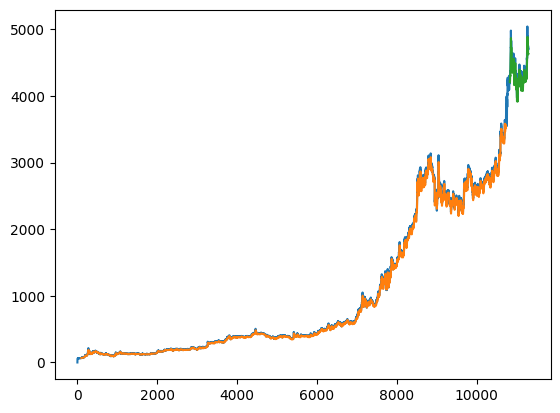

In [19]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df2)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()